<a href="https://colab.research.google.com/github/fboldt/aulasann/blob/main/aula12a_nlp_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

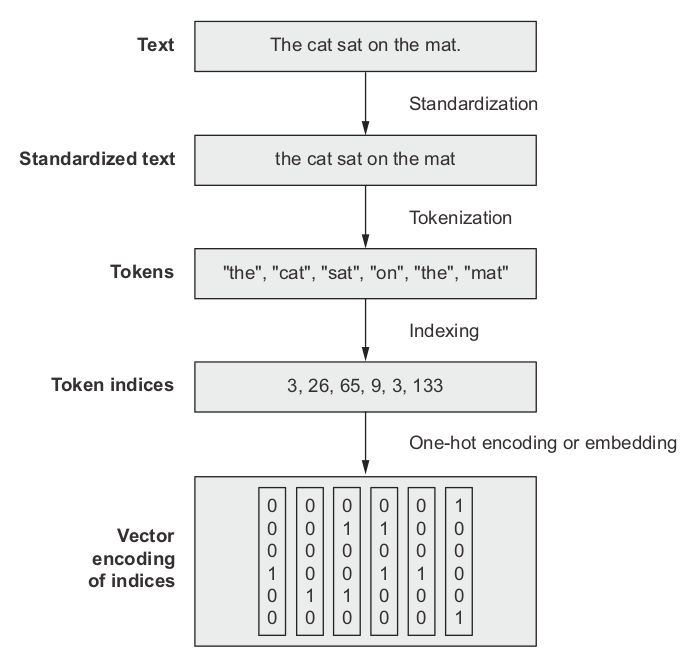

In [1]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup
!cat aclImdb/train/pos/4077_10.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  7888k      0  0:00:10  0:00:10 --:--:-- 16.5M
I first saw this back in the early 90s on UK TV, i did like it then but i missed the chance to tape it, many years passed but the film always stuck with me and i lost hope of seeing it TV again, the main thing that stuck with me was the end, the hole castle part really touched me, its easy to watch, has a great story, great music, the list goes on and on, its OK me saying how good it is but everyone will take there own best bits away with them once they have seen it, yes the animation is top notch and beautiful to watch, it does show its age in a very few parts but that has now become part of it beauty, i am so glad it has came out on DVD as it is one of my top 10 films of all time. Buy it or rent it just see it, best viewing is at night alone with drin

In [2]:
import os, pathlib, shutil, random

base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    os.makedirs(val_dir / category)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)


In [3]:
from tensorflow import keras
batch_size = 32

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [4]:
for inputs, targets in train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break

inputs.shape: (32,)
inputs.dtype: <dtype: 'string'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor(b'This documentary is at its best when it is simply showing the ayurvedic healers\' offices and treatment preparation. There is no denying the grinding poverty in India and desperation of even their wealthier clients. However, as an argument for ayurvedic medicine in general, this film fails miserably. Although Indian clients mention having seen "aleopathic" doctors, those doctors are not interviewed, and we have to take the vague statements of their patients at face value-- "the doctor said there was no cure," "the doctor said it was cancer" etc. Well, "no cure" doesn\'t mean "no treatment," and what type of cancer exactly does the patient have? The film is at its most feeble when showing ayurvedic practice in America. There it is reduced, apparently, to the stunning suggestion that having a high powered Wall Street job can make your stomach hurt.', shape=(), d

In [6]:
from tensorflow.keras.layers import TextVectorization

text_vectorization = TextVectorization(
    max_tokens = 20000,
    output_mode = "multi_hot",
)
text_only_train_ds = train_ds.map(lambda x, y: x)
text_vectorization.adapt(text_only_train_ds)

binary_1gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_1gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_1gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)


In [7]:
for inputs, targets in binary_1gram_train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break

inputs.shape: (32, 20000)
inputs.dtype: <dtype: 'float32'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor([1. 1. 1. ... 0. 0. 0.], shape=(20000,), dtype=float32)
targets[0]: tf.Tensor(0, shape=(), dtype=int32)


In [8]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(max_tokens=20000, hidden_dim=16):
  inputs = keras.Input(shape=(max_tokens,))
  x = layers.Dense(hidden_dim, activation="relu")(inputs)
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(1, activation="sigmoid")(x)
  model = keras.Model(inputs, outputs)
  model.compile(optimizer="rmsprop",
                loss="binary_crossentropy",
                metrics=["accuracy"])
  return model

In [10]:
model = get_model()
model.summary()
callbacks = [
    keras.callbacks.ModelCheckpoint("binary_1gram.keras",
                                    save_best_only=True)
]
model.fit(binary_1gram_train_ds.cache(),
          validation_data = binary_1gram_val_ds.cache(),
          epochs = 10,
          callbacks = callbacks)
model = keras.models.load_model("binary_1gram.keras")
print(f"Test acc: {model.evaluate(binary_1gram_test_ds)[1]:.3f}")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_2 (Dense)             (None, 16)                320016    
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 21s 33ms/step - loss: 0.4086 - accuracy: 0.8286 - val_loss: 0.2904 - val_accuracy: 0.8812
Epoch 2/10
625/625 [=====================

In [11]:
text_vectorization = TextVectorization(
    ngrams = 2,
    max_tokens = 20000,
    output_mode = "multi_hot",
)
text_vectorization.adapt(text_only_train_ds)
binary_2gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls = 4)
binary_2gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls = 4)
binary_2gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls = 4)


In [12]:
model = get_model()
model.summary()
callbacks = [
    keras.callbacks.ModelCheckpoint("binary_2gram.keras",
                                    save_best_only=True)
]
model.fit(binary_2gram_train_ds.cache(),
          validation_data = binary_2gram_val_ds.cache(),
          epochs = 10,
          callbacks = callbacks)
model = keras.models.load_model("binary_2gram.keras")
print(f"Test acc: {model.evaluate(binary_2gram_test_ds)[1]:.3f}")

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_4 (Dense)             (None, 16)                320016    
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 12s 18ms/step - loss: 0.3972 - accuracy: 0.8309 - val_loss: 0.2678 - val_accuracy: 0.8944
Epoch 2/10
625/625 [=====================

In [13]:
text_vectorization = TextVectorization(
    ngrams = 2,
    max_tokens = 20000,
    output_mode = "count",
)

In [14]:
text_vectorization = TextVectorization(
    ngrams = 2,
    max_tokens = 20000,
    output_mode = "tf_idf",
)

In [15]:
text_vectorization.adapt(text_only_train_ds)

tfidf_2gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls = 4)
tfidf_2gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls = 4)
tfidf_2gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls = 4)

In [16]:
for inputs, targets in tfidf_2gram_train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break

inputs.shape: (32, 20000)
inputs.dtype: <dtype: 'float32'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor(
[676.9046      8.369398    5.6870575 ...   0.          0.
   0.       ], shape=(20000,), dtype=float32)
targets[0]: tf.Tensor(1, shape=(), dtype=int32)


In [17]:
model = get_model()
model.summary()
callbacks = [
    keras.callbacks.ModelCheckpoint("tfidf_2gram.keras",
                                    save_best_only=True)
]
model.fit(tfidf_2gram_train_ds.cache(),
          validation_data = tfidf_2gram_val_ds.cache(),
          epochs = 10,
          callbacks = callbacks)
model = keras.models.load_model("tfidf_2gram.keras")
print(f"Test acc: {model.evaluate(tfidf_2gram_test_ds)[1]:.3f}")

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_6 (Dense)             (None, 16)                320016    
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 14s 22ms/step - loss: 0.5154 - accuracy: 0.7552 - val_loss: 0.3403 - val_accuracy: 0.8846
Epoch 2/10
625/625 [=====================